<a href="https://colab.research.google.com/github/shoban-0-fsd/bskearner.github.io/blob/master/docs/tutorials/tfx/penguin_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple TFX Pipeline Tutorial using Penguin dataset

***A Short tutorial to run a simple TFX pipeline.***

Note: We recommend running this tutorial in a Colab notebook, with no setup required!  Just click "Run in Google Colab".

<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/tfx/penguin_simple">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png"/>View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/tfx/penguin_simple.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/tree/master/docs/tutorials/tfx/penguin_simple.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/tfx/penguin_simple.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td>
</table></div>

In this notebook-based tutorial, we will create and run a TFX pipeline
for a simple classification model.
The pipeline will consist of three essential TFX components: ExampleGen,
Trainer and Pusher. The pipeline includes the most minimal ML workflow like
importing data, training a model and exporting the trained model.

Please see
[Understanding TFX Pipelines](https://www.tensorflow.org/tfx/guide/understanding_tfx_pipelines)
to learn more about various concepts in TFX.

## Set Up
We first need to install the TFX Python package and download
the dataset which we will use for our model.

### Upgrade Pip

To avoid upgrading Pip in a system when running locally,
check to make sure that we are running in Colab.
Local systems can of course be upgraded separately.

In [1]:
try:
  import colab
  !pip install --upgrade pip
except:
  pass

### Install TFX


In [1]:
!pip install -U tfx

### Uninstall shapely

TODO(b/263441833) This is a temporal solution to avoid an
ImportError. Ultimately, it should be handled by supporting a
recent version of Bigquery, instead of uninstalling other extra
dependencies.

In [2]:
!pip uninstall shapely -y

Found existing installation: shapely 2.0.2
Uninstalling shapely-2.0.2:
  Successfully uninstalled shapely-2.0.2


### Did you restart the runtime?

If you are using Google Colab, the first time that you run
the cell above, you must restart the runtime by clicking
above "RESTART RUNTIME" button or using "Runtime > Restart
runtime ..." menu. This is because of the way that Colab
loads packages.

Check the TensorFlow and TFX versions.

In [3]:
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

TensorFlow version: 2.13.1
TFX version: 1.14.0


### Set up variables

There are some variables used to define a pipeline. You can customize these
variables as you want. By default all output from the pipeline will be
generated under the current directory.

In [4]:
import os

PIPELINE_NAME = "penguin-simple"

# Output directory to store artifacts generated from the pipeline.
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE_NAME)
# Path to a SQLite DB file to use as an MLMD storage.
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'metadata.db')
# Output directory where created models from the pipeline will be exported.
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)

from absl import logging
logging.set_verbosity(logging.INFO)  # Set default logging level.

### Prepare example data
We will download the example dataset for use in our TFX pipeline. The dataset we
are using is
[Palmer Penguins dataset](https://allisonhorst.github.io/palmerpenguins/articles/intro.html)
which is also used in other
[TFX examples](https://github.com/tensorflow/tfx/tree/master/tfx/examples/penguin).

There are four numeric features in this dataset:

- culmen_length_mm
- culmen_depth_mm
- flipper_length_mm
- body_mass_g

All features were already normalized to have range [0,1]. We will build a
classification model which predicts the `species` of penguins.

Because TFX ExampleGen reads inputs from a directory, we need to create a
directory and copy dataset to it.

In [5]:
import urllib.request
import tempfile

DATA_ROOT = tempfile.mkdtemp(prefix='tfx-data')  # Create a temporary directory.
_data_url = 'https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/penguin/data/labelled/penguins_processed.csv'
_data_filepath = os.path.join(DATA_ROOT, "data.csv")
urllib.request.urlretrieve(_data_url, _data_filepath)

('/tmp/tfx-data_jb2chaq/data.csv', <http.client.HTTPMessage at 0x796078c6c9d0>)

Take a quick look at the CSV file.

In [6]:
!head {_data_filepath}

species,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,0.2545454545454545,0.6666666666666666,0.15254237288135594,0.2916666666666667
0,0.26909090909090905,0.5119047619047618,0.23728813559322035,0.3055555555555556
0,0.29818181818181805,0.5833333333333334,0.3898305084745763,0.1527777777777778
0,0.16727272727272732,0.7380952380952381,0.3559322033898305,0.20833333333333334
0,0.26181818181818167,0.892857142857143,0.3050847457627119,0.2638888888888889
0,0.24727272727272717,0.5595238095238096,0.15254237288135594,0.2569444444444444
0,0.25818181818181823,0.773809523809524,0.3898305084745763,0.5486111111111112
0,0.32727272727272727,0.5357142857142859,0.1694915254237288,0.1388888888888889
0,0.23636363636363636,0.9642857142857142,0.3220338983050847,0.3055555555555556


You should be able to see five values. `species` is one of 0, 1 or 2, and all
other features should have values between 0 and 1.

## Create a pipeline

TFX pipelines are defined using Python APIs. We will define a pipeline which
consists of following three components.
- CsvExampleGen: Reads in data files and convert them to TFX internal format
for further processing. There are multiple
[ExampleGen](https://www.tensorflow.org/tfx/guide/examplegen)s for various
formats. In this tutorial, we will use CsvExampleGen which takes CSV file input.
- Trainer: Trains an ML model.
[Trainer component](https://www.tensorflow.org/tfx/guide/trainer) requires a
model definition code from users. You can use TensorFlow APIs to specify how to
train a model and save it in a _saved_model_ format.
- Pusher: Copies the trained model outside of the TFX pipeline.
[Pusher component](https://www.tensorflow.org/tfx/guide/pusher) can be thought
of as a deployment process of the trained ML model.

Before actually define the pipeline, we need to write a model code for the
Trainer component first.

### Write model training code

We will create a simple DNN model for classification using TensorFlow Keras
API. This model training code will be saved to a separate file.

In this tutorial we will use
[Generic Trainer](https://www.tensorflow.org/tfx/guide/trainer#generic_trainer)
of TFX which support Keras-based models. You need to write a Python file
containing `run_fn` function, which is the entrypoint for the `Trainer`
component.

In [7]:
_trainer_module_file = 'penguin_trainer.py'

In [8]:
%%writefile {_trainer_module_file}

from typing import List
from absl import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow_transform.tf_metadata import schema_utils

from tfx import v1 as tfx
from tfx_bsl.public import tfxio
from tensorflow_metadata.proto.v0 import schema_pb2

_FEATURE_KEYS = [
    'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'
]
_LABEL_KEY = 'species'

_TRAIN_BATCH_SIZE = 20
_EVAL_BATCH_SIZE = 10

# Since we're not generating or creating a schema, we will instead create
# a feature spec.  Since there are a fairly small number of features this is
# manageable for this dataset.
_FEATURE_SPEC = {
    **{
        feature: tf.io.FixedLenFeature(shape=[1], dtype=tf.float32)
           for feature in _FEATURE_KEYS
       },
    _LABEL_KEY: tf.io.FixedLenFeature(shape=[1], dtype=tf.int64)
}


def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              schema: schema_pb2.Schema,
              batch_size: int = 200) -> tf.data.Dataset:
  """Generates features and label for training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    schema: schema of the input data.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  return data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_LABEL_KEY),
      schema=schema).repeat()


def _build_keras_model() -> tf.keras.Model:
  """Creates a DNN Keras model for classifying penguin data.

  Returns:
    A Keras Model.
  """
  # The model below is built with Functional API, please refer to
  # https://www.tensorflow.org/guide/keras/overview for all API options.
  inputs = [keras.layers.Input(shape=(1,), name=f) for f in _FEATURE_KEYS]
  d = keras.layers.concatenate(inputs)
  for _ in range(2):
    d = keras.layers.Dense(8, activation='relu')(d)
  outputs = keras.layers.Dense(3)(d)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(
      optimizer=keras.optimizers.Adam(1e-2),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])

  model.summary(print_fn=logging.info)
  return model


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """

  # This schema is usually either an output of SchemaGen or a manually-curated
  # version provided by pipeline author. A schema can also derived from TFT
  # graph if a Transform component is used. In the case when either is missing,
  # `schema_from_feature_spec` could be used to generate schema from very simple
  # feature_spec, but the schema returned would be very primitive.
  schema = schema_utils.schema_from_feature_spec(_FEATURE_SPEC)

  train_dataset = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      schema,
      batch_size=_TRAIN_BATCH_SIZE)
  eval_dataset = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      schema,
      batch_size=_EVAL_BATCH_SIZE)

  model = _build_keras_model()
  model.fit(
      train_dataset,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps)

  # The result of the training should be saved in `fn_args.serving_model_dir`
  # directory.
  model.save(fn_args.serving_model_dir, save_format='tf')

Writing penguin_trainer.py


Now you have completed all preparation steps to build a TFX pipeline.

### Write a pipeline definition

We define a function to create a TFX pipeline. A `Pipeline` object
represents a TFX pipeline which can be run using one of the pipeline
orchestration systems that TFX supports.


In [9]:
def _create_pipeline(pipeline_name: str, pipeline_root: str, data_root: str,
                     module_file: str, serving_model_dir: str,
                     metadata_path: str) -> tfx.dsl.Pipeline:
  """Creates a three component penguin pipeline with TFX."""
  # Brings data into the pipeline.
  example_gen = tfx.components.CsvExampleGen(input_base=data_root)

  # Uses user-provided Python function that trains a model.
  trainer = tfx.components.Trainer(
      module_file=module_file,
      examples=example_gen.outputs['examples'],
      train_args=tfx.proto.TrainArgs(num_steps=100),
      eval_args=tfx.proto.EvalArgs(num_steps=5))

  # Pushes the model to a filesystem destination.
  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory=serving_model_dir)))

  # Following three components will be included in the pipeline.
  components = [
      example_gen,
      trainer,
      pusher,
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

## Run the pipeline

TFX supports multiple orchestrators to run pipelines.
In this tutorial we will use `LocalDagRunner` which is included in the TFX
Python package and runs pipelines on local environment.
We often call TFX pipelines "DAGs" which stands for directed acyclic graph.

`LocalDagRunner` provides fast iterations for development and debugging.
TFX also supports other orchestrators including Kubeflow Pipelines and Apache
Airflow which are suitable for production use cases.

See
[TFX on Cloud AI Platform Pipelines](https://www.tensorflow.org/tfx/tutorials/tfx/cloud-ai-platform-pipelines)
or
[TFX Airflow Tutorial](https://www.tensorflow.org/tfx/tutorials/tfx/airflow_workshop)
to learn more about other orchestration systems.

Now we create a `LocalDagRunner` and pass a `Pipeline` object created from the
function we already defined.

The pipeline runs directly and you can see logs for the progress of the pipeline including ML model training.

In [10]:
tfx.orchestration.LocalDagRunner().run(
  _create_pipeline(
      pipeline_name=PIPELINE_NAME,
      pipeline_root=PIPELINE_ROOT,
      data_root=DATA_ROOT,
      module_file=_trainer_module_file,
      serving_model_dir=SERVING_MODEL_DIR,
      metadata_path=METADATA_PATH))

INFO:absl:Generating ephemeral wheel package for '/content/penguin_trainer.py' (including modules: ['penguin_trainer']).
INFO:absl:User module package has hash fingerprint version a7e2e8dccbb913b74904edeec5549d868a2ea392bcd84fbc1965aba698dce3fc.
INFO:absl:Executing: ['/usr/bin/python3', '/tmp/tmpy8t63f0h/_tfx_generated_setup.py', 'bdist_wheel', '--bdist-dir', '/tmp/tmpeqx0r1tv', '--dist-dir', '/tmp/tmpkjl8x1up']
INFO:absl:Successfully built user code wheel distribution at 'pipelines/penguin-simple/_wheels/tfx_user_code_Trainer-0.0+a7e2e8dccbb913b74904edeec5549d868a2ea392bcd84fbc1965aba698dce3fc-py3-none-any.whl'; target user module is 'penguin_trainer'.
INFO:absl:Full user module path is 'penguin_trainer@pipelines/penguin-simple/_wheels/tfx_user_code_Trainer-0.0+a7e2e8dccbb913b74904edeec5549d868a2ea392bcd84fbc1965aba698dce3fc-py3-none-any.whl'
INFO:absl:Using deployment config:
 executor_specs {
  key: "CsvExampleGen"
  value {
    beam_executable_spec {
      python_executor_spec {
  

INFO:absl:Processing input csv data /tmp/tfx-data_jb2chaq/* to TFExample.
INFO:absl:Examples generated.
INFO:absl:Value type <class 'NoneType'> of key version in exec_properties is not supported, going to drop it
INFO:absl:Value type <class 'list'> of key _beam_pipeline_args in exec_properties is not supported, going to drop it
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 1 succeeded.
INFO:absl:Cleaning up stateful execution info.
INFO:absl:Publishing output artifacts defaultdict(<class 'list'>, {'examples': [Artifact(artifact: uri: "pipelines/penguin-simple/CsvExampleGen/examples/1"
custom_properties {
  key: "input_fingerprint"
  value {
    string_value: "split:single_split,num_files:1,total_bytes:25648,xor_checksum:1702029278,sum_checksum:1702029278"
  }
}
custom_properties {
  key: "span"
  value {
    int_value: 0
  }
}
, artifact_type: name: "Examples"
properties {
  key: "span"
  value: INT
}
properties {
  key: "split_names"
  value: STRING
}
properties 

100/100 [==============================] - 1s 4ms/step - loss: 0.5399 - sparse_categorical_accuracy: 0.8135 - val_loss: 0.2293 - val_sparse_categorical_accuracy: 0.9200


INFO:absl:Function `_wrapped_model` contains input name(s) resource with unsupported characters which will be renamed to model_dense_2_biasadd_readvariableop_resource in the SavedModel.
INFO:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:absl:Writing fingerprint to pipelines/penguin-simple/Trainer/model/2/Format-Serving/fingerprint.pb
INFO:absl:Training complete. Model written to pipelines/penguin-simple/Trainer/model/2/Format-Serving. ModelRun written to pipelines/penguin-simple/Trainer/model_run/2
INFO:absl:Cleaning up stateless execution info.
INFO:absl:Execution 2 succeeded.
INFO:absl:Cleaning up stateful execution info.
INFO:absl:Publishing output artifacts defaultdict(<class 'list'>, {'model': [Artifact(artifact: uri: "pipelines/penguin-simple/Trainer/model/2"
, artifact_type: name: "Model"
base_type: MODEL
)], 'model_run': [Artifact(artifact: uri: "pipelines/penguin-simple/Tr

You should see "INFO:absl:Component Pusher is finished." at the end of the
logs if the pipeline finished successfully. Because `Pusher` component is the
last component of the pipeline.

The pusher component pushes the trained model to the `SERVING_MODEL_DIR` which
is the `serving_model/penguin-simple` directory if you did not change the
variables in the previous steps. You can see the result from the file browser
in the left-side panel in Colab, or using the following command:

In [11]:
# List files in created model directory.
!find {SERVING_MODEL_DIR}

serving_model/penguin-simple
serving_model/penguin-simple/1702029483
serving_model/penguin-simple/1702029483/fingerprint.pb
serving_model/penguin-simple/1702029483/saved_model.pb
serving_model/penguin-simple/1702029483/assets
serving_model/penguin-simple/1702029483/keras_metadata.pb
serving_model/penguin-simple/1702029483/variables
serving_model/penguin-simple/1702029483/variables/variables.index
serving_model/penguin-simple/1702029483/variables/variables.data-00000-of-00001


In [12]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize pixel values to the range [0, 1]
y_train = to_categorical(y_train, 10)  # One-hot encode labels
y_test = to_categorical(y_test, 10)


11490434/11490434 [==============================] - 0s 0us/step


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# Build the neural network
model = Sequential([
    Flatten(input_shape=(28, 28)),  # Flatten the 28x28 input images
    Dense(128, activation='relu'),   # Dense layer with 128 units and ReLU activation
    Dense(10, activation='softmax')  # Output layer with 10 units (for each digit) and softmax activation
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))



Epoch 1/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2573 - accuracy: 0.9263 - val_loss: 0.1356 - val_accuracy: 0.9604
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1147 - accuracy: 0.9663 - val_loss: 0.1038 - val_accuracy: 0.9696
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0791 - accuracy: 0.9759 - val_loss: 0.0848 - val_accuracy: 0.9741
Epoch 4/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0586 - accuracy: 0.9820 - val_loss: 0.0819 - val_accuracy: 0.9752
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0457 - accuracy: 0.9858 - val_loss: 0.0767 - val_accuracy: 0.9766


In [15]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")



313/313 [==============================] - 1s 2ms/step - loss: 0.0767 - accuracy: 0.9766
Test Accuracy: 97.66%


In [16]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Set up TensorBoard callback
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model with TensorBoard callback
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])



Epoch 1/5
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0364 - accuracy: 0.9884 - val_loss: 0.0782 - val_accuracy: 0.9781
Epoch 2/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0290 - accuracy: 0.9912 - val_loss: 0.0756 - val_accuracy: 0.9771
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0242 - accuracy: 0.9922 - val_loss: 0.0700 - val_accuracy: 0.9801
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0193 - accuracy: 0.9945 - val_loss: 0.0741 - val_accuracy: 0.9774
Epoch 5/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0154 - accuracy: 0.9952 - val_loss: 0.0866 - val_accuracy: 0.9768


In [17]:
import tensorflow as tf

# Generate synthetic data
x_train = [1, 2, 3, 4, 5]
y_train = [2, 4, 6, 8, 10]

# Build a simple linear regression model
model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100)


Epoch 1/100
1/1 [==============================] - 0s 466ms/step - loss: 39.9317
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 23.2882
Epoch 3/100
1/1 [==============================] - 0s 11ms/step - loss: 13.5890
Epoch 4/100
1/1 [==============================] - 0s 11ms/step - loss: 7.9367
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 4.6427
Epoch 6/100
1/1 [==============================] - 0s 9ms/step - loss: 2.7230
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 1.6042
Epoch 8/100
1/1 [==============================] - 0s 11ms/step - loss: 0.9521
Epoch 9/100
1/1 [==============================] - 0s 12ms/step - loss: 0.5719
Epoch 10/100
1/1 [==============================] - 0s 16ms/step - loss: 0.3503
Epoch 11/100
1/1 [==============================] - 0s 11ms/step - loss: 0.2210
Epoch 12/100
1/1 [==============================] - 0s 10ms/step - loss: 0.1456
Epoch 13/100
1/1 [=============================

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


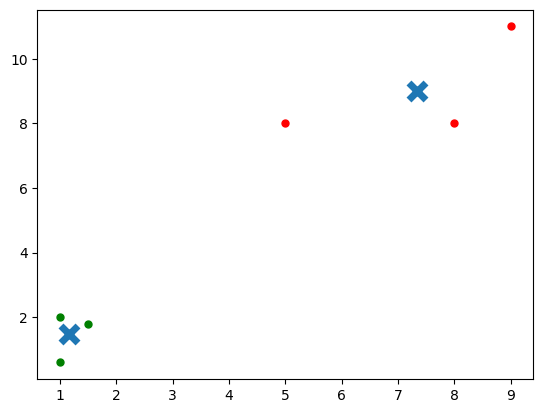

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data
X = np.array([[1, 2], [5, 8], [1.5, 1.8], [8, 8], [1, 0.6], [9, 11]])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Visualize the clusters
colors = ["g.", "r."]
for i in range(len(X)):
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize=10)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=150, linewidths=5)
plt.show()


In [19]:
import gym

env = gym.make('CartPole-v1')
state = env.reset()

for _ in range(1000):
    env.render()
    action = env.action_space.sample()  # Random action
    state, reward, done, _ = env.step(action)

    if done:
        state = env.reset()
env.close()


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don

In [21]:
gym.make('CartPole-v1', render_mode='human')

<TimeLimit<OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>>

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Generate synthetic data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Build a simple neural network
model = Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")


Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2927 - accuracy: 0.9154
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1410 - accuracy: 0.9582
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1073 - accuracy: 0.9671
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0874 - accuracy: 0.9728
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0772 - accuracy: 0.9760
Test accuracy: 0.9760000109672546


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Generate synthetic data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Expand dimensions for CNN input
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Build a simple CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")


Epoch 1/5
1875/1875 [==============================] - 40s 21ms/step - loss: 0.1457 - accuracy: 0.9574
Epoch 2/5
1875/1875 [==============================] - 44s 24ms/step - loss: 0.0494 - accuracy: 0.9851
Epoch 3/5
1875/1875 [==============================] - 40s 22ms/step - loss: 0.0304 - accuracy: 0.9906
Epoch 4/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0203 - accuracy: 0.9934
Epoch 5/5
313/313 [==============================] - 2s 6ms/step - loss: 0.0504 - accuracy: 0.9843
Test accuracy: 0.9843000173568726


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Generate synthetic data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=10000)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=200)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=200)

# Build a simple RNN
model = Sequential([
    Embedding(10000, 32, input_length=200),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")


17464789/17464789 [==============================] - 0s 0us/step
Epoch 1/5
782/782 [==============================] - 141s 177ms/step - loss: 0.4269 - accuracy: 0.8026
Epoch 2/5
782/782 [==============================] - 140s 179ms/step - loss: 0.2629 - accuracy: 0.8973
Epoch 3/5
782/782 [==============================] - 141s 181ms/step - loss: 0.2024 - accuracy: 0.9230
Epoch 4/5
782/782 [==============================] - 137s 175ms/step - loss: 0.1603 - accuracy: 0.9415
Epoch 5/5
782/782 [==============================] - 40s 50ms/step - loss: 0.3846 - accuracy: 0.8584
Test accuracy: 0.8583599925041199


In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np

# Load MNIST data
(x_train, _), (_, _) = mnist.load_data()

# Normalize pixel values to the range [0, 1]
x_train = x_train / 255.0

# Reshape images to (28, 28, 1) and expand dimensions
x_train = np.expand_dims(x_train, axis=-1)

# Define a function to get real images
def get_real_images(batch_size):
    indices = np.random.randint(0, x_train.shape[0], size=batch_size)
    real_images = x_train[indices]
    return real_images
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define parameters
epochs = 10000  # Adjust as needed
batch_size = 64

# Define a generator model
generator = Sequential([
    Dense(128, input_shape=(100,), activation='relu'),
    Dense(784, activation='sigmoid'),
    Reshape((28, 28, 1))
])

# Define a discriminator model
discriminator = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Combine generator and discriminator into a GAN model
discriminator.trainable = False
gan = Sequential([generator, discriminator])

# Compile the models
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Training loop
for epoch in range(epochs):
    noise = np.random.normal(0, 1, [batch_size, 100])
    generated_images = generator.predict(noise)
    real_images = get_real_images(batch_size)  # Replace with the actual function

    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_images, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)

    # Train generator (via the whole GAN model)
    noise = np.random.normal(0, 1, [batch_size, 100])
    labels_gan = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, labels_gan)

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} | Discriminator Loss: {0.5 * np.add(d_loss_real, d_loss_fake)} | Generator Loss: {g_loss}")


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
Epoch 5100/10000 | Discriminator Loss: 5.274880290031433 | Generator Loss: 6.24880995019339e-05
2/2 [==============================] - 0s 7ms/step
Epoch 5200/10000 | Discriminator Loss: 5.254715979099274 | Generator Loss: 6.036588456481695e-05
2/2 [==============================] - 0s 5ms/step
Epoch 5300/10000 | Discriminator Loss: 5.331273108720779 | Generator Loss: 5.781073195976205e-05
2/2 [==============================] - 0s 5ms/step
Epoch 5400/10000 | Discriminator Loss: 5.360953271389008 | Generator Loss: 5.632708052871749e-05
2/2 [==============================] - 0s 5ms/step
Epoch 5500/10000 | Discriminator Loss: 5.382245302200317 | Generator Loss: 5.0982973334612325e-05
2/2 [==============================] - 0s 14ms/step
Epoch 5600/10000 | Discriminator Loss: 5.355077803134918 | Generator Loss: 4.742128658108413e-05
2/2 [==============================] - 0s 10ms/step
Epoch 57

In [29]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf

# Load pre-trained transformer model and tokenizer
model_name = "bert-base-uncased"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example text
text = "Transformers are amazing for natural language processing tasks!"

# Tokenize and encode the text
inputs = tokenizer(text, return_tensors="tf")

# Forward pass through the model
outputs = model(**inputs)

# Access logits (raw scores before softmax) for classification
logits = outputs.logits
print(logits)



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tf.Tensor([[-0.04651273 -0.13994735]], shape=(1, 2), dtype=float32)


In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Sample text data
texts = ["This is the first document.", "This document is the second document.", "And this is the third one."]

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# Print the word index
print("Word Index:")
print(word_index)


Word Index:
{'this': 1, 'is': 2, 'the': 3, 'document': 4, 'first': 5, 'second': 6, 'and': 7, 'third': 8, 'one': 9}


In [31]:
import spacy

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Sample text for NER
text = "Apple is planning to build a new research center in California."

# Process the text with spaCy
doc = nlp(text)

# Extract named entities
entities = [(ent.text, ent.label_) for ent in doc.ents]

# Print named entities
print("Named Entities:")
print(entities)


Named Entities:
[('Apple', 'ORG'), ('California', 'GPE')]


In [32]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf

# Load pre-trained sentiment analysis model and tokenizer (using Hugging Face Transformers)
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example text for sentiment analysis
text = "I love using TensorFlow for natural language processing tasks!"

# Tokenize and encode the text
inputs = tokenizer(text, return_tensors="tf")

# Forward pass through the model
outputs = model(**inputs)

# Access logits (raw scores before softmax) for sentiment classification
logits = outputs.logits
predicted_class = tf.argmax(logits, axis=1).numpy()[0]

# Print predicted sentiment class
print("Predicted Sentiment Class:", predicted_class)


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/670M [00:00<?, ?B/s]

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Predicted Sentiment Class: 4


In [4]:
!pip install --upgrade tensorflow
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:
      Successfully uninstalled tensorboard-2.13.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.13.1
    Uninstalling tensorflow-2.13.1:
      Successfully

In [2]:
!pip install sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 5.6 MB/s eta 0:00:00


## Next steps

You can find more resources on https://www.tensorflow.org/tfx/tutorials.

Please see
[Understanding TFX Pipelines](https://www.tensorflow.org/tfx/guide/understanding_tfx_pipelines)
to learn more about various concepts in TFX.


In [17]:
# Install required packages
!pip install tf_slim

# Clone the TensorFlow models repository
!git clone https://github.com/tensorflow/models.git

# Run the model builder test
!python models/research/object_detection/builders/model_builder_tf2_test.py


Cloning into 'models'...
remote: Enumerating objects: 90151, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 90151 (delta 96), reused 117 (delta 62), pack-reused 89980
Receiving objects: 100% (90151/90151), 606.64 MiB | 25.60 MiB/s, done.
Resolving deltas: 100% (64937/64937), done.
2023-12-08 13:48:59.011639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/content/models/research/object_detection/builders/model_builder_tf2_test.py", line 24, in <module>
    from object_detection.builders import model_builder
ModuleNotFoundError: No module named 'object_detection'


In [18]:
# Install the face_recognition library
!pip install face_recognition


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=aaa27d25e36e6da961dcc58d3fb2e25f666c5dbff5e98bf42559bfda029811a3
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [19]:
!pip install SpeechRecognition


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 26.7 MB/s eta 0:00:00


In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dot, Flatten
from tensorflow.keras.models import Model

# Sample data for users, items, and ratings
num_users = 1000
num_items = 500
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

# User and item embeddings
user_embedding = Embedding(output_dim=50, input_dim=num_users, input_length=1)(user_input)
item_embedding = Embedding(output_dim=50, input_dim=num_items, input_length=1)(item_input)

# Dot product to get predicted ratings
dot_product = Dot(axes=1)([user_embedding, item_embedding])
predicted_rating = Flatten()(dot_product)

# Model
model_collaborative = Model(inputs=[user_input, item_input], outputs=predicted_rating)

# Compile the model
model_collaborative.compile(optimizer='adam', loss='mean_squared_error')

import numpy as np

# Sample data (replace with your actual data)
num_users = 1000
num_items = 500
user_ids = np.random.randint(0, num_users, size=1000)
item_ids = np.random.randint(0, num_items, size=1000)
ratings = np.random.randint(1, 6, size=1000)

# Assume you have user_ids, item_ids, and ratings
user_input_data = np.reshape(user_ids, (-1, 1))
item_input_data = np.reshape(item_ids, (-1, 1))

# Train the collaborative model
model_collaborative.fit([user_input_data, item_input_data], ratings, epochs=10, batch_size=32)

# Make predictions for new data
new_user_ids = np.array([1, 2, 3, 4])
new_item_ids = np.array([10, 20, 30, 40])
new_user_input_data = np.reshape(new_user_ids, (-1, 1))
new_item_input_data = np.reshape(new_item_ids, (-1, 1))

predictions_collaborative = model_collaborative.predict([new_user_input_data, new_item_input_data])
print("Predictions (Collaborative):", predictions_collaborative)

# Train the model with your data
# ...

# Make predictions
# ...



Epoch 1/10
32/32 [==============================] - 1s 4ms/step - loss: 11.2530
Epoch 2/10
32/32 [==============================] - 0s 3ms/step - loss: 11.2528
Epoch 3/10
32/32 [==============================] - 0s 3ms/step - loss: 11.2521
Epoch 4/10
32/32 [==============================] - 0s 3ms/step - loss: 11.2504
Epoch 5/10
32/32 [==============================] - 0s 3ms/step - loss: 11.2473
Epoch 6/10
32/32 [==============================] - 0s 3ms/step - loss: 11.2426
Epoch 7/10
32/32 [==============================] - 0s 3ms/step - loss: 11.2360
Epoch 8/10
32/32 [==============================] - 0s 3ms/step - loss: 11.2277
Epoch 9/10
32/32 [==============================] - 0s 3ms/step - loss: 11.2176
Epoch 10/10
1/1 [==============================] - 0s 87ms/step
Predictions (Collaborative): [[ 3.5699795e-03  2.4873251e-03  4.4417651e-03 ... -1.7722882e-03
  -2.3455413e-03 -1.7266272e-03]
 [-3.6630323e-03  2.9117446e-03 -2.3237660e-06 ...  1.4258773e-03
  -7.0693917e-03  2.59

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Dense, Concatenate
from tensorflow.keras.models import Model

# Sample data for items and features
num_items = 500
num_features = 50
item_input = Input(shape=(1,), name='item_input')
feature_input = Input(shape=(num_features,), name='feature_input')

# Item embedding
item_embedding = Embedding(output_dim=50, input_dim=num_items, input_length=1)(item_input)
item_embedding_flat = Flatten()(item_embedding)

# Concatenate item embedding with features
concatenated = Concatenate()([item_embedding_flat, feature_input])

# Fully connected layers for prediction
dense_layer = Dense(64, activation='relu')(concatenated)
output_layer = Dense(1, activation='linear')(dense_layer)

# Model
model_content_based = Model(inputs=[item_input, feature_input], outputs=output_layer)

# Compile the model
model_content_based.compile(optimizer='adam', loss='mean_squared_error')

import numpy as np
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.models import Model

# Sample data (replace with your actual data)
num_items = 500
num_features = 50
num_ratings = 1000

item_ids = np.arange(num_items)
item_features = np.random.rand(num_items, num_features)

# Assume you have item_ids and item_features
item_input_data = np.reshape(item_ids, (-1, 1))

# Create the content-based model architecture
item_input = Input(shape=(1,))
item_embedding = Embedding(input_dim=num_items, output_dim=num_features)(item_input)
item_embedding_flatten = Flatten()(item_embedding)
item_features_input = Input(shape=(num_features,))
concatenated = Concatenate()([item_embedding_flatten, item_features_input])
output = Dense(1)(concatenated)

model_content_based = Model(inputs=[item_input, item_features_input], outputs=output)
model_content_based.compile(optimizer='adam', loss='mean_squared_error')

# Generate synthetic ratings data
ratings = np.random.randint(1, 6, size=len(item_input_data))

# Assume you have item_input_data and item_features
model_content_based.fit([item_input_data, item_features], ratings, epochs=10, batch_size=32)

# Make predictions for new data
new_item_ids = np.array([10, 20, 30, 40])
new_item_features = np.random.rand(len(new_item_ids), num_features)
new_item_input_data = np.reshape(new_item_ids, (-1, 1))

predictions_content_based = model_content_based.predict([new_item_input_data, new_item_features])
print("Predictions (Content-Based):", predictions_content_based)

# Train the model with your data
# ...

# Make predictions
# ...


Epoch 1/10
16/16 [==============================] - 1s 3ms/step - loss: 9.4329
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 7.3155
Epoch 3/10
16/16 [==============================] - 0s 2ms/step - loss: 5.6736
Epoch 4/10
16/16 [==============================] - 0s 2ms/step - loss: 4.4011
Epoch 5/10
16/16 [==============================] - 0s 2ms/step - loss: 3.4845
Epoch 6/10
16/16 [==============================] - 0s 2ms/step - loss: 2.8293
Epoch 7/10
16/16 [==============================] - 0s 2ms/step - loss: 2.3577
Epoch 8/10
16/16 [==============================] - 0s 2ms/step - loss: 2.0141
Epoch 9/10
16/16 [==============================] - 0s 2ms/step - loss: 1.7437
Epoch 10/10
1/1 [==============================] - 0s 68ms/step
Predictions (Content-Based): [[3.2994947]
 [2.6491432]
 [2.5830247]
 [2.6818433]]


In [27]:
import numpy as np
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate some synthetic data
num_users = 100
num_items = 50
num_features = 10

user_ids = np.random.randint(0, num_users, size=1000)
item_ids = np.random.randint(0, num_items, size=1000)
ratings = np.random.randint(1, 6, size=1000)
user_features = np.random.rand(num_users, num_features)
item_features = np.random.rand(num_items, num_features)

# Split the data into training and testing sets
user_ids_train, user_ids_test, item_ids_train, item_ids_test, ratings_train, ratings_test = train_test_split(
    user_ids, item_ids, ratings, test_size=0.2, random_state=42
)

# User and item embeddings
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

user_embedding = Embedding(input_dim=num_users, output_dim=50)(user_input)
item_embedding = Embedding(input_dim=num_items, output_dim=50)(item_input)

user_flat = Flatten()(user_embedding)
item_flat = Flatten()(item_embedding)

# Concatenate user and item embeddings
merged = Concatenate()([user_flat, item_flat])

# Fully connected layers for collaborative filtering
fc1 = Dense(100, activation='relu')(merged)
fc2 = Dense(50, activation='relu')(fc1)

# Fully connected layer for content-based filtering
item_features_input = Input(shape=(num_features,), name='item_features_input')
fc_content = Dense(50, activation='relu')(item_features_input)

# Concatenate collaborative and content-based layers
merged_hybrid = Concatenate()([fc2, fc_content])

# Final prediction layer
output = Dense(1, activation='linear', name='prediction')(merged_hybrid)

# Build the model
model = Model(inputs=[user_input, item_input, item_features_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit([user_ids_train, item_ids_train, item_features[item_ids_train]], ratings_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
evaluation = model.evaluate([user_ids_test, item_ids_test, item_features[item_ids_test]], ratings_test)
print("Evaluation Loss:", evaluation[0])
print("Evaluation MAE:", evaluation[1])

# Make predictions
predictions = model.predict([user_ids_test, item_ids_test, item_features[item_ids_test]])


Epoch 1/10
23/23 [==============================] - 3s 23ms/step - loss: 7.7319 - mae: 2.4119 - val_loss: 5.3103 - val_mae: 1.9418
Epoch 2/10
23/23 [==============================] - 0s 8ms/step - loss: 3.4850 - mae: 1.5178 - val_loss: 1.7133 - val_mae: 1.1311
Epoch 3/10
23/23 [==============================] - 0s 7ms/step - loss: 1.9274 - mae: 1.1823 - val_loss: 1.6834 - val_mae: 1.1058
Epoch 4/10
23/23 [==============================] - 0s 7ms/step - loss: 1.7226 - mae: 1.1179 - val_loss: 1.7051 - val_mae: 1.1111
Epoch 5/10
23/23 [==============================] - 0s 6ms/step - loss: 1.6342 - mae: 1.0926 - val_loss: 1.7761 - val_mae: 1.1366
Epoch 6/10
23/23 [==============================] - 0s 7ms/step - loss: 1.5950 - mae: 1.0765 - val_loss: 1.8671 - val_mae: 1.1674
Epoch 7/10
23/23 [==============================] - 0s 7ms/step - loss: 1.5788 - mae: 1.0665 - val_loss: 1.9284 - val_mae: 1.1903
Epoch 8/10
23/23 [==============================] - 0s 7ms/step - loss: 1.5606 - mae: 1.0

!pip install pyautogui

In [10]:
!git clone https://github.com/buguroo/pyknow.git



Cloning into 'pyknow'...
remote: Enumerating objects: 2625, done.
remote: Total 2625 (delta 0), reused 0 (delta 0), pack-reused 2625
Receiving objects: 100% (2625/2625), 1.69 MiB | 12.20 MiB/s, done.
Resolving deltas: 100% (1699/1699), done.


In [15]:
!pip install scikit-fuzzy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894077 sha256=a9e15ea651f588be0d7b662728f7bdba4eaa3444eb612b26b31aeead944f7265
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [16]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Create Antecedents and Consequents
temperature = ctrl.Antecedent(np.arange(0, 101, 1), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')
fan_speed = ctrl.Consequent(np.arange(0, 101, 1), 'fan_speed')

# Define fuzzy membership functions
temperature['low'] = fuzz.trimf(temperature.universe, [0, 0, 50])
temperature['medium'] = fuzz.trimf(temperature.universe, [0, 50, 100])
temperature['high'] = fuzz.trimf(temperature.universe, [50, 100, 100])

humidity['low'] = fuzz.trimf(humidity.universe, [0, 0, 50])
humidity['medium'] = fuzz.trimf(humidity.universe, [0, 50, 100])
humidity['high'] = fuzz.trimf(humidity.universe, [50, 100, 100])

fan_speed['low'] = fuzz.trimf(fan_speed.universe, [0, 0, 50])
fan_speed['medium'] = fuzz.trimf(fan_speed.universe, [0, 50, 100])
fan_speed['high'] = fuzz.trimf(fan_speed.universe, [50, 100, 100])

# Define fuzzy rules
rule1 = ctrl.Rule(temperature['low'] & humidity['low'], fan_speed['low'])
rule2 = ctrl.Rule(temperature['medium'] & humidity['medium'], fan_speed['medium'])
rule3 = ctrl.Rule(temperature['high'] & humidity['high'], fan_speed['high'])

# Create control system
fan_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
fan_ctrl_sim = ctrl.ControlSystemSimulation(fan_ctrl)

# Pass inputs to the control system
fan_ctrl_sim.input['temperature'] = 30
fan_ctrl_sim.input['humidity'] = 70

# Compute the result
fan_ctrl_sim.compute()

# Print the result
print(f"Fan Speed: {fan_ctrl_sim.output['fan_speed']:.2f}%")


Fan Speed: 50.00%


In [17]:
!pip install deap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.7 MB/s eta 0:00:00


In [18]:
import random
from deap import base, creator, tools, algorithms

# Define the evaluation function
def evaluate(individual):
    # Example: Minimize the squared difference from a target value
    target_value = 42
    return (individual[0] - target_value)**2,

# Create a genetic algorithm
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -100, 100)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Create the population
population = toolbox.population(n=50)

# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=50, stats=None, halloffame=None, verbose=True)

# Print the best individual
best_individual = tools.selBest(population, k=1)[0]
print("Best Individual:", best_individual)


gen	nevals
0  	50    
1  	40    
2  	35    
3  	37    
4  	34    
5  	36    
6  	45    
7  	37    
8  	42    
9  	38    
10 	37    
11 	34    
12 	37    
13 	44    
14 	41    
15 	38    
16 	36    
17 	36    
18 	39    
19 	40    
20 	39    
21 	37    
22 	33    
23 	31    
24 	39    
25 	23    
26 	38    
27 	39    
28 	38    
29 	44    
30 	45    
31 	39    
32 	43    
33 	43    
34 	38    
35 	38    
36 	37    
37 	38    
38 	41    
39 	44    
40 	37    
41 	44    
42 	35    
43 	37    
44 	36    
45 	31    
46 	41    
47 	44    
48 	40    
49 	35    
50 	41    
Best Individual: [42.0]


In [19]:
!pip install pyswarms


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.1 MB/s eta 0:00:00


In [20]:
import numpy as np
import tensorflow as tf
import pyswarms as ps

# Define the function to be minimized
def sphere(x):
    return np.sum(x**2)

# Define the objective function
def objective_function(position):
    # Reshape the position to match the TensorFlow model input shape
    x = tf.constant(position.reshape(1, -1), dtype=tf.float32)

    # Example: Minimize the squared difference from a target value
    target_value = 0.0
    return tf.reduce_sum((x - target_value)**2).numpy()

# Create a swarm with 10 particles, each having 2 dimensions
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options)

# Run the optimization
best_position, _ = optimizer.optimize(objective_function, iters=100)

# Print the best position found
print("Best Position:", best_position)


2023-12-08 15:06:09,620 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.857
2023-12-08 15:06:10,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8573230504989624, best pos: [ 0.38714028 -0.20477558]


Best Position: 0.8573230504989624


In [ ]:
import tensorflow as tf
from collections import deque
import random


# Simulated environment
class DroneEnvironment:
    def __init__(self):
        self.position = [0, 0, 0]

    def move(self, action):
        # Simulated movement based on action
        if action == 0:  # Assuming 0 represents left
            self.position[0] -= 1
        elif action == 1:  # Assuming 1 represents right
            self.position[0] += 1
        # Add more cases if needed for other dimensions

        # Simulated reward function (modify as needed)
        reward = 1 if self.position[0] == 10 else 0

        # Simulated termination condition (modify as needed)
        done = self.position[0] == 10

        return self.position, reward, done


# Deep Q-Network (DQN) for drone control
class DQNModel(tf.keras.Model):
    def __init__(self, num_actions):
        super(DQNModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.output_layer = tf.keras.layers.Dense(num_actions, activation='linear')

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        return self.output_layer(x)


# Define your replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        # Check if there are enough samples in the buffer
        if len(self.buffer) < batch_size:
            raise ValueError("Not enough samples in the replay buffer")

        # Sample a random batch from the replay buffer
        batch = random.sample(self.buffer, batch_size)

        return batch

# Example usage
buffer = ReplayBuffer(capacity=1000)

# Ensure the replay buffer has enough samples before sampling a batch
if len(buffer.buffer) >= batch_size:
    batch = buffer.sample(batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
else:
    print("Not enough samples in the replay buffer")

# Training parameters
learning_rate = 0.001
gamma = 0.99
epsilon = 0.1
num_actions = 4  # Example: Up, Down, Left, Right
buffer_capacity = 1000
batch_size = 32

# Create instances
environment = DroneEnvironment()
model = DQNModel(num_actions)
optimizer = tf.optimizers.Adam(learning_rate)
buffer = ReplayBuffer(buffer_capacity)


# Training loop
num_episodes = 100
for episode in range(num_episodes):
    state = environment.position
    done = False  # Add this line
    total_reward = 0

    while not done:
        # Epsilon-greedy exploration
        if random.uniform(0, 1) < epsilon:
            action = random.choice(range(num_actions))
        else:
            q_values = model(tf.convert_to_tensor([state], dtype=tf.float32))
            action = tf.argmax(q_values[0]).numpy()

        # Take action in the environment
        next_state, reward, done = environment.move(action)

        # Store experience in replay buffer
        buffer.add((state, action, reward, next_state, done))

        # Check if the replay buffer has enough samples before sampling a batch
        if len(buffer.buffer) >= batch_size:
            # Sample a random batch from the replay buffer
            batch = buffer.sample(batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            # Convert 'dones' to a NumPy array
            dones = tf.convert_to_tensor(dones, dtype=tf.float32)

            # Calculate target Q-values
            target_q_values = rewards + gamma * tf.reduce_max(model(tf.convert_to_tensor(next_states, dtype=tf.float32)), axis=1)
            target_q_values = target_q_values * (1.0 - dones) - dones

            with tf.GradientTape() as tape:
                # Calculate predicted Q-values
                q_values = model(tf.convert_to_tensor(states, dtype=tf.float32))
                selected_action_values = tf.reduce_sum(q_values * tf.one_hot(actions, num_actions), axis=1)

                # Calculate loss
                loss = tf.reduce_mean(tf.square(target_q_values - selected_action_values))

            # Update model
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Move to the next state
        state = next_state
        total_reward += reward

    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")


Not enough samples in the replay buffer
Episode: 1, Total Reward: 1
Episode: 2, Total Reward: 1
Episode: 3, Total Reward: 1
Episode: 4, Total Reward: 1
Episode: 5, Total Reward: 1
Episode: 6, Total Reward: 1
Episode: 7, Total Reward: 1
Episode: 8, Total Reward: 1
Episode: 9, Total Reward: 1
Episode: 10, Total Reward: 1
Episode: 11, Total Reward: 1
Episode: 12, Total Reward: 1
Episode: 13, Total Reward: 1
Episode: 14, Total Reward: 1
Episode: 15, Total Reward: 1
Episode: 16, Total Reward: 1
Episode: 17, Total Reward: 1
Episode: 18, Total Reward: 1
Episode: 19, Total Reward: 1
Episode: 20, Total Reward: 1
Episode: 21, Total Reward: 1
Episode: 22, Total Reward: 1
Episode: 23, Total Reward: 1
Episode: 24, Total Reward: 1
Episode: 25, Total Reward: 1
Episode: 26, Total Reward: 1
Episode: 27, Total Reward: 1
Episode: 28, Total Reward: 1
Episode: 29, Total Reward: 1
Episode: 30, Total Reward: 1
Episode: 31, Total Reward: 1
Episode: 32, Total Reward: 1
Episode: 33, Total Reward: 1
Episode: 34,

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy

# Define the quantum circuit
qubits = cirq.GridQubit.rect(1, 2)
circuit = cirq.Circuit()
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.CNOT(qubits[0], qubits[1]))

# Define the symbols for the quantum circuit
symbols = sympy.symbols('alpha beta gamma delta')
param_resolver = cirq.ParamResolver({key: val for key, val in zip(symbols, [0.1, 0.2, 0.3, 0.4])})
resolved_circuit = cirq.resolve_parameters(circuit, param_resolver)

# Convert the circuit to a TensorFlow Quantum circuit
tfq_circuit = tfq.convert_to_tensor([resolved_circuit])

# Define a simple quantum model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    tfq.layers.PQC(circuit, [cirq.Z(qubits[0])])
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error')

# Generate some training data
train_data = tfq.convert_to_tensor([resolved_circuit] * 100)
train_labels = tf.convert_to_tensor([[1.0] * 100])

# Train the quantum model
model.fit(train_data, train_labels, epochs=10)
